In [1]:
import tensorflow as tf
import numpy as np
import os
import sys
from importlib import reload
from datetime import datetime

sys.path.insert(0, '../src')
import deepgeo.dataset.data_augment as dtaug
import deepgeo.dataset.utils as dsutils 
import deepgeo.common.geofunctions as gf
import deepgeo.networks.model_builder as mb
import deepgeo.networks.loss_functions as lossf

reload(dtaug)
reload(dsutils)
reload(mb)
reload(gf)

/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<module 'deepgeo.common.geofunctions' from '../src/deepgeo/common/geofunctions.py'>

# Load input Dataset

In [2]:
# DATA_DIR = os.path.join(os.path.abspath(os.path.dirname('__file__')), '../', 'data_real', 'generated')
network = 'unet'
fusion = 'none'
DATA_DIR = '/home/raian/doutorado/Dados/generated'

DATASET = os.path.join(DATA_DIR, 'dataset_286x286_def_one_class_SR-2013-2017')
dataset_fldr = 'def_one_class'

class_names = ['no data', 'not deforestation', 'deforestation', 'clouds']
# model_dir = os.path.join(DATA_DIR, 'tf_logs', 'experiments', 'unet', dataset_fldr, 'fusion_%s' % fusion,
#                          'test_%s_%s' % (network, datetime.now().strftime('%d_%m_%Y-%H_%M_%S')))
model_dir = os.path.join(DATA_DIR, 'tf_logs', 'experiments', 'unet', 'def_one_class',
                             'fusion_%s' % fusion, 'test_unet_2019_07_12-00_14_47')
train_tfrecord = os.path.join(DATASET, 'dataset_train.tfrecord')
test_tfrecord = os.path.join(DATASET, 'dataset_test.tfrecord')
val_dataset = os.path.join(DATASET, 'dataset_valid.npz')

In [3]:
# model_dir = '/home/raian/doutorado/deepgeo/data_real/generated/tf_logs/test_debug'
# !rm -rf {model_dir}/*
# !ls -al {model_dir}

## Computing weights

In [4]:
weights_train = lossf.compute_weights_inv_squared_proportion(train_tfrecord, class_names, []) # ['no data'])
weights_eval = lossf.compute_weights_inv_squared_proportion(test_tfrecord, class_names, []) #['no data'])

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
print(weights_train)
print(weights_eval)

[17.28558185318838, 5.231304593229233, 17.871766578220488, 136.10904650306685]
[18.967199286727652, 5.110682154015075, 18.108671712763236, 115.50206132606849]


In [6]:
params = {
    'network': network,
    'fusion': fusion,
    'epochs': 1,
    'batch_size': 20,
    'chip_size': 286,
    'bands': 10,
    'filter_reduction': 0.5,
    'learning_rate': 0.1,
    'learning_rate_decay': True,
    'decay_rate': 0.95 ,
    'l2_reg_rate': 0.0005,
    # 'var_scale_factor': 2.0,  # TODO: Put the initializer as parameter
    'chips_tensorboard': 2,
    # 'dropout_rate': 0.5,  # TODO: Put a bool parameter to apply or not Dropout
    'loss_func': 'avg_generalized_dice',
    'data_aug_ops': ['rot90', 'rot180', 'rot270', 'flip_left_right',
                     'flip_up_down', 'flip_transpose'],
    'data_aug_per_chip': 4,
    'class_weights': {'train': weights_train, 'eval': weights_eval},
    'num_classes': len(class_names),
    'class_names': class_names,
    'num_cofrom mpositions': 2,
    'bands_plot': [[1, 2, 3], [6, 7, 8]],
    'Notes': 'Testing.'
}

# Train the Network

In [7]:
reload(mb)

<module 'deepgeo.networks.model_builder' from '../src/deepgeo/networks/model_builder.py'>

In [8]:
# model = mb.ModelBuilder(params)
# model.train(train_tfrecord, test_tfrecord, model_dir)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/raian/doutorado/Dados/generated/tf_logs/experiments/unet/def_one_class/fusion_none/test_unet_2019_07_12-00_14_47/mode

/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<<------------------------------------------------------------>>
<<------------------ Validation Results ---------------------->>
<<------------------------------------------------------------>>
F1-Score:
  - no_data: 0.0
  - not_deforestation: 0.956110044800312
  - deforestation: 0.6973093223721146
  - clouds: 0.8461921833549731
Precision:
  - no_data: 0.0
  - not_deforestation: 0.9637874040054799
  - deforestation: 0.550438783219361
  - clouds: 0.7491664289191927
Recall:
  - no_data: 0.0
  - not_deforestation: 0.9485540319302811
  - deforestation: 0.9510810143690961
  - clouds: 0.9720890001003992
Accuracy: 0.7579608739837398
AUC-ROC clouds: {'clouds': 0.9947708754104796, 'no_data': 0.9992758412810192, 'not_deforestation': 0.9899848171026424, 'deforestation': 0.9762738008431133}
AUC-ROC no_data: {'clouds': 0.9947708754104796, 'no_data': 0.9992758412810192, 'not_deforestation': 0.9899848171026424, 'deforestation': 0.9762738008431133}
AUC-ROC not_deforestation: {'clouds': 0.994770875410

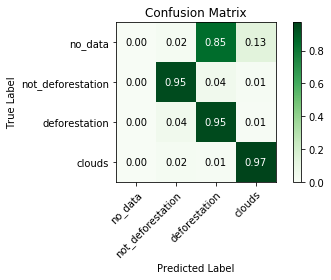

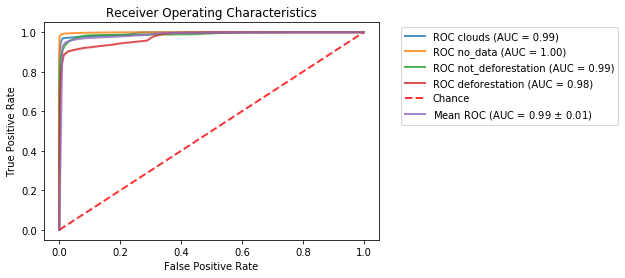

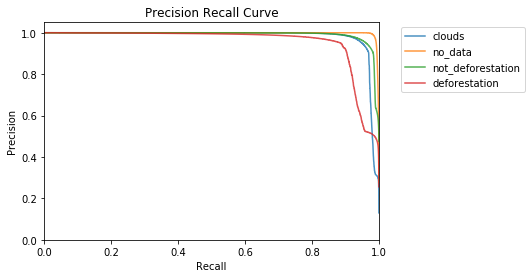

In [9]:
dataset = np.load(val_dataset)
model = mb.ModelBuilder(model_dir)
model.validate(dataset['chips'], dataset['labels'], model_dir, exclude_classes=[])